## Exercise #2: Data Analysis and Visualization
- Ended up not bearing fruit.

In [1]:
# Cell 1: Import Libraries
# Import necessary libraries for data analysis, clustering, and visualization.
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Cell 2: Load and Preview the Data
# Load the Excel file and display the first few rows of the dataset to understand its structure.
exercise_2_df = pd.read_excel('../data/Exercise #2.xlsx')
exercise_2_df.head()


,MIRC subpractice,attorney on case,client birthdate,client country of origin,client language,client city,immigration court location,event_type,event_date,application/petition type,application/petition outcome date (if applicable),application/petition outcome,court hearing is remote or in-person?,reason for application/petition denial provided by USCIS,reason for case/representation ended (if applicable)
0,Released,BB,2008-02-10,Afghanistan,NaN,Grand Rapids,Detroit,Application/petition filed,2022-09-13 00:00:00,I-485,2022-09-21,Denied,NaN,Fee not included,NaN
1,Released,BB,NaT,Afghanistan,NaN,Kalamazoo,Detroit,Application/petition filed,2022-11-12 00:00:00,I-360,2022-11-23,Denied,NaN,Request for evidence not responded to,NaN
2,Released,DD,2008-03-29,Afghanistan,Pashto,Ypsilanti,Detroit,Application/petition filed,2022-12-16 00:00:00,State Court Petition,NaT,Pending,NaN,NaN,Immigration Relief Granted
3,Released,CC,2005-06-12,Afghanistan,NaN,Traverse City,Detroit,Application/petition filed,2022-09-22 00:00:00,State Court Petition,2022-10-01,Granted,NaN,NaN,NaN
4,Released,CC,2004-03-15,Afghanistan,NaN,Traverse City,Detroit,Application/petition filed,2022-12-22 00:00:00,State Court Petition,NaT,Pending,NaN,NaN,NaN


In [3]:
# Cell 3: Handle Datetime Columns
# Check and convert 'event_date' to datetime format, then calculate 'ProcessingTime' as the difference in days.
print(exercise_2_df['event_date'].dtype)
exercise_2_df['event_date'] = pd.to_datetime(exercise_2_df['event_date'], errors='coerce')
exercise_2_df['ProcessingTime'] = (exercise_2_df['application/petition outcome date (if applicable)'] - exercise_2_df['event_date']).dt.days


object


In [4]:
# Cell 4: Preprocess the Data
# Fill missing values in 'ProcessingTime' and handle datetime columns by converting them to timestamps.
cluster_src_df = exercise_2_df.copy()
cluster_src_df['ProcessingTime'] = cluster_src_df['ProcessingTime'].fillna(-1)

datetime_columns = ['client birthdate', 'event_date', 'application/petition outcome date (if applicable)']

for col in datetime_columns:
    # Convert datetime to datetime objects if they are not already
    cluster_src_df[col] = pd.to_datetime(cluster_src_df[col], errors='coerce')

# Apply Label Encoding to categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in datetime_columns:
    cluster_src_df[col] = label_encoder.fit_transform(cluster_src_df[col].astype(str))

# Check the transformed dataframe
print(cluster_src_df.head())


  MIRC subpractice attorney on case  client birthdate  \
0         Released               BB                80   
1         Released               BB               148   
2         Released               DD                88   
3         Released               CC                22   
4         Released               CC                 5   

  client country of origin client language    client city  \
0              Afghanistan             NaN   Grand Rapids   
1              Afghanistan             NaN      Kalamazoo   
2              Afghanistan          Pashto      Ypsilanti   
3              Afghanistan             NaN  Traverse City   
4              Afghanistan             NaN  Traverse City   

  immigration court location                  event_type  event_date  \
0                    Detroit  Application/petition filed          33   
1                    Detroit  Application/petition filed          67   
2                    Detroit  Application/petition filed          87   
3 

In [5]:
# Cell 5: Identify and Encode Categorical Columns
# Identify columns with a limited number of unique values and apply one-hot encoding to them.
threshold = 30
potential_categorical_columns = [col for col in cluster_src_df.columns if cluster_src_df[col].nunique() <= threshold]
print("Potentially categorical columns based on unique values:", potential_categorical_columns)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), potential_categorical_columns)],
    remainder='passthrough')
df_encoded = preprocessor.fit_transform(cluster_src_df)
feature_names = preprocessor.get_feature_names_out()
print(feature_names)


Potentially categorical columns based on unique values: ['MIRC subpractice', 'attorney on case', 'client country of origin', 'client language', 'client city', 'immigration court location', 'event_type', 'application/petition type ', 'application/petition outcome', 'court hearing is remote or in-person?', 'reason for application/petition denial provided by USCIS', 'reason for case/representation ended (if applicable)']
['cat__MIRC subpractice_Released' 'cat__attorney on case_AA'
 'cat__attorney on case_BB' 'cat__attorney on case_CC'
 'cat__attorney on case_DD' 'cat__attorney on case_EE'
 'cat__attorney on case_FF' 'cat__attorney on case_GG'
 'cat__attorney on case_HH' 'cat__attorney on case_II'
 'cat__attorney on case_JJ' 'cat__attorney on case_nan'
 'cat__client country of origin_Afghanistan'
 'cat__client country of origin_Angola'
 'cat__client country of origin_Bangladesh'
 'cat__client country of origin_Cuba'
 'cat__client country of origin_El Salvador'
 'cat__client country of orig

In [6]:
# Cell 6: Standardize the Features
# Standardize the encoded features to have zero mean and unit variance before clustering.
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded)


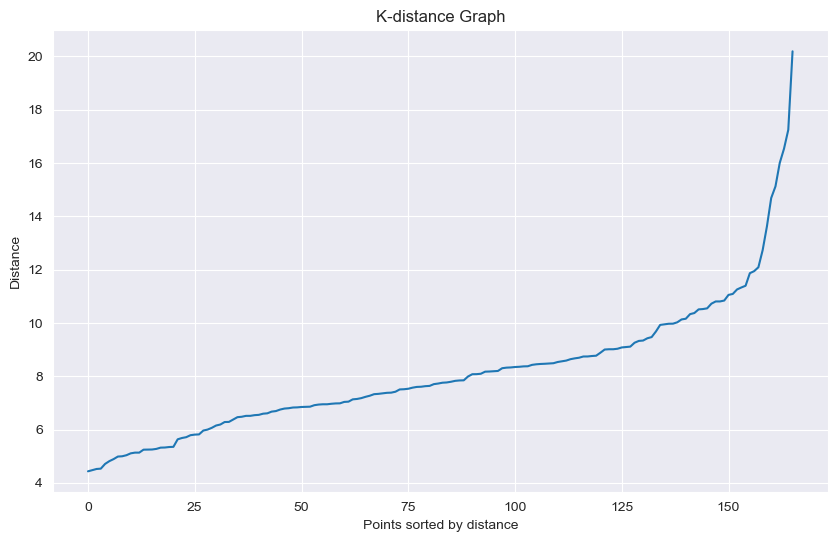

Selected `eps`: 20.189641892959056
Selected `min_samples`: 5


In [7]:
# Cell 7: Determine `eps` and `min_samples` from K-distance Graph
# Plot the K-distance graph to find an appropriate `eps` value for DBSCAN.
from sklearn.neighbors import NearestNeighbors

# Compute the distances to the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5).fit(df_encoded_scaled)
distances, _ = neighbors.kneighbors(df_encoded_scaled)
distances = np.sort(distances[:, 4], axis=0)

# Plot the K-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# Find the index of the "elbow" in the K-distance plot
# This can be done manually by inspecting the plot or using an automated method
elbow_index = np.argmax(np.diff(distances, 2)) + 2  # +2 because of zero-based indexing and first differences

# Set `eps` as the distance at the elbow index
eps = distances[elbow_index]

# For `min_samples`, a common heuristic is to set it slightly larger than the k used in NearestNeighbors
min_samples = 5  # Example value; you may adjust based on the data's density

print(f"Selected `eps`: {eps}")
print(f"Selected `min_samples`: {min_samples}")


In [8]:
# Cell 8: Apply DBSCAN Clustering with Iterative Parameters
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import numpy as np
import logging
from tqdm import tqdm  # For progress bar

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def calculate_silhouette_score(encoded_data, labels):
    """Calculate the silhouette score for the given labels."""
    try:
        return silhouette_score(encoded_data, labels)
    except ValueError:
        return None  # Silhouette score cannot be computed if only one cluster

def get_cluster_size_distribution(labels):
    """Get the distribution of cluster sizes."""
    unique_labels, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique_labels, counts))

def evaluate_dbscan_parameters(encoded_data, eps_val, min_samples_val):
    """Evaluate DBSCAN clustering with given eps and min_samples."""
    dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
    labels = dbscan.fit_predict(encoded_data)
    
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if num_clusters > 2:
        score = calculate_silhouette_score(encoded_data, labels)
        cluster_sizes = get_cluster_size_distribution(labels)
        return score, cluster_sizes, labels, num_clusters
    return None, None, None, None

def find_best_dbscan_params(encoded_data, eps_candidates, min_samples_candidates):
    """Find the best DBSCAN parameters by evaluating multiple combinations."""
    best_score = -1
    best_eps = None
    best_min_samples = None
    best_labels = None
    best_cluster_sizes = None
    best_num_clusters = None
    
    best_score_criteria = -1
    best_eps_criteria = None
    best_min_samples_criteria = None
    best_labels_criteria = None
    best_cluster_sizes_criteria = None
    best_num_clusters_criteria = None
    
    total_combinations = len(eps_candidates) * len(min_samples_candidates)
    
    # Initialize tqdm progress bar with total number of combinations
    with tqdm(total=total_combinations, desc="Evaluating DBSCAN Parameters", ncols=100, unit="combination") as pbar:
        for eps_val in eps_candidates:
            for min_samples_val in min_samples_candidates:
                score, cluster_sizes, labels, num_clusters = evaluate_dbscan_parameters(encoded_data, eps_val, min_samples_val)
                
                # Update the best results regardless of criteria
                if score is not None and (score > best_score_criteria or best_score_criteria == -1):
                    best_score_criteria = score
                    best_eps_criteria = eps_val
                    best_min_samples_criteria = min_samples_val
                    best_labels_criteria = labels
                    best_cluster_sizes_criteria = cluster_sizes
                    best_num_clusters_criteria = num_clusters

                # Update the best results if they meet the criteria
                if score is not None and score > best_score and all(size > 5 for size in cluster_sizes.values()):  # Adjust threshold as needed
                    best_score = score
                    best_eps = eps_val
                    best_min_samples = min_samples_val
                    best_labels = labels
                    best_cluster_sizes = cluster_sizes
                    best_num_clusters = num_clusters
                
                # Update progress bar
                pbar.update(1)
    
    # Output the best results regardless of criteria
    if best_eps_criteria is not None:
        print(f"Best results (even if criteria not fully met): eps={best_eps_criteria}, min_samples={best_min_samples_criteria} with Silhouette Score: {best_score_criteria}")
        print(f"Cluster Size Distribution: {best_cluster_sizes_criteria}")

    if best_eps is not None:
        print(f"Best parameters meeting criteria: eps={best_eps}, min_samples={best_min_samples} with Silhouette Score: {best_score}")
        print(f"Cluster Size Distribution: {best_cluster_sizes}")
        return best_eps, best_min_samples, best_labels, best_num_clusters
    else:
        print("No valid parameters found that meet all criteria. Displaying the best results found.")
        return best_eps_criteria, best_min_samples_criteria, best_labels_criteria, best_num_clusters_criteria

# Define ranges of `eps` and `min_samples` to iterate over
eps_candidates = np.arange(0.1, 120.0, 0.1)  # Adjust range and step as needed
min_samples_candidates = range(2, 20)     # Adjust range as needed

# Find the best parameters
best_eps, best_min_samples, best_dbscan_labels, best_num_clusters = find_best_dbscan_params(df_encoded_scaled, eps_candidates, min_samples_candidates)

if best_eps is not None and best_min_samples is not None:
    # Extract the core clusters (excluding noise)
    core_cluster_mask = best_dbscan_labels != -1
    core_cluster_data = df_encoded_scaled[core_cluster_mask]

    print(f"Final number of core clusters: {best_num_clusters}")
    print(f"Selected `eps`: {best_eps}")
    print(f"Selected `min_samples`: {best_min_samples}")
else:
    # Handle the case where no suitable parameters were found
    print("No suitable parameters found. Clustering may be invalid.")
    cluster_src_df['KMeans_Labels'] = np.nan

Evaluating DBSCAN Parameters: 100%|█████████████████| 21582/21582 [01:06<00:00, 325.87combination/s]
INFO:__main__:Best results (even if criteria not fully met): eps=10.0, min_samples=2 with Silhouette Score: 0.17740691890706475
INFO:__main__:Cluster Size Distribution: {-1: 9, 0: 151, 1: 2, 2: 4}
INFO:__main__:No valid parameters found that meet all criteria. Displaying the best results found.
INFO:__main__:Final number of core clusters: 3
INFO:__main__:Selected `eps`: 10.0
INFO:__main__:Selected `min_samples`: 2


In [9]:
# Cell 9: Apply KMeans Clustering
# Fit KMeans to the core clusters identified by DBSCAN and add the KMeans labels to the original dataframe.

if eps is not None and min_samples is not None and best_num_clusters > 1:
    if 'KMeans_Labels' in cluster_src_df.columns:
        # Reset KMeans_Labels if it already exists to avoid issues with re-running
        cluster_src_df['KMeans_Labels'] = np.nan
    
    kmeans = KMeans(n_clusters=best_num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(core_cluster_data)
    cluster_src_df.loc[core_cluster_mask, 'KMeans_Labels'] = kmeans_labels
else:
    # Handle the case where KMeans clustering parameters are not valid
    print("KMeans clustering not applied due to invalid parameters or insufficient clusters.")
    if 'KMeans_Labels' not in cluster_src_df.columns:
        cluster_src_df['KMeans_Labels'] = np.nan

C:\Users\Marvin Kassabian\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


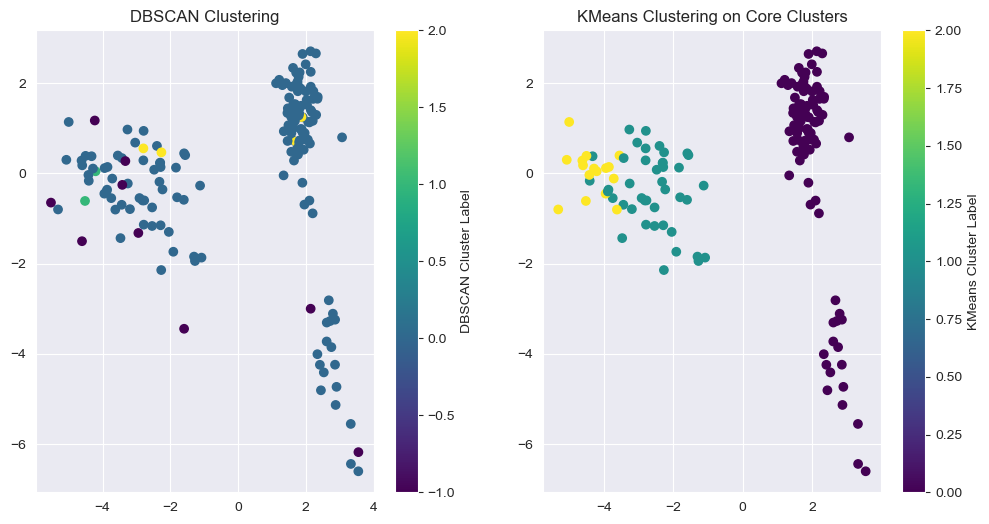

In [10]:
# Cell 10: Visualize the Clustering Results
# Use PCA to reduce dimensionality and visualize the clustering results from both DBSCAN and KMeans.
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded_scaled)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=best_dbscan_labels, cmap='viridis', marker='o')
plt.colorbar(label='DBSCAN Cluster Label')
plt.title("DBSCAN Clustering")

if 'KMeans_Labels' in cluster_src_df.columns:
    plt.subplot(1, 2, 2)
    plt.scatter(df_pca[core_cluster_mask, 0], df_pca[core_cluster_mask, 1], c=kmeans_labels, cmap='viridis', marker='o')
    plt.colorbar(label='KMeans Cluster Label')
    plt.title("KMeans Clustering on Core Clusters")

plt.show()

In [11]:
# Cell 11: Output DataFrame with Clustering Results
# Add the DBSCAN and KMeans clustering results to the original DataFrame.
exercise_2_df['DBSCAN_Labels'] = best_dbscan_labels

if 'KMeans_Labels' in cluster_src_df.columns:
    exercise_2_df['KMeans_Labels'] = cluster_src_df['KMeans_Labels'].reindex(exercise_2_df.index)

exercise_2_df.head()

exercise_2_df.to_excel('../output/Exercise_2_with_clustering_results.xlsx', index=False)
